### 作業目的: 實作word2vec Skip-gram模型
在課程中了解如何搭建CBOW模型，這次的作業目的在於透過搭建Skip-gram模型來了解另外一種word2vec的架構。

Hint_1: 學員可以善用課程中以搭建好的function模組
Hint_2: Skip_gram所需的輸入資料與目標跟CBOW有些許不同，Skip_gram是由中間字詞預測上下文

In [1]:
# import modules
import numpy as np
from typing import List
from utils.utility import clip_grads, convert_one_hot, preprocess, Trainer
from utils.layers import Dense, SoftmaxWithCrossEntropy
from utils.optimizer import SGD

In [3]:
# use the same corpus as in the lecture
text = "I am studying Natural Language Processing now."

# define create_contexts_target function
def create_contexts_target(corpus: List, window_size: int=1):
    contexts = []
    targets = corpus[window_size:-window_size]
    
    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            # center             
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)

    return np.array(contexts), np.array(targets)

# transform corpus to contexts and targets pair
corpus, word2idx, idx2word = preprocess([text])
contexts, targets= create_contexts_target(corpus[0], window_size=1)
corpus,contexts, targets

(array([[1, 7, 2, 0, 3, 6, 4, 5]]),
 array([[1, 2],
        [7, 0],
        [2, 3],
        [0, 6],
        [3, 4],
        [6, 5]]),
 array([7, 2, 0, 3, 6, 4]))

In [4]:
# transform contexts and targets to one-hot encoding
def convert2onehot(corpus, vocab_size):
    N = corpus.shape[0]
    
    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype = np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1
    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype = np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot

contexts = convert2onehot(contexts, len(word2idx))
targets = convert2onehot(targets, len(word2idx))
contexts, targets

(array([[[0, 1, 0, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0, 0, 0]],
 
        [[0, 0, 0, 0, 0, 0, 0, 1],
         [1, 0, 0, 0, 0, 0, 0, 0]],
 
        [[0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0, 0]],
 
        [[1, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1, 0]],
 
        [[0, 0, 0, 1, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0, 0]],
 
        [[0, 0, 0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 1, 0, 0]]], dtype=int32),
 array([[0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0, 0, 0]], dtype=int32))

In [5]:
# define Skip-gram model
class SkipGram:
    def __init__(self, vocab_size, hidden_size, window_size):
        V, H = vocab_size, hidden_size
        self.window_size = window_size

        # initialize weights
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # create layers
        self.in_layer = Dense(W_in)
        self.out_layer = [Dense(W_out) for i in range(window_size*2)]
        self.loss_layers = SoftmaxWithCrossEntropy()
        

        layers = self.in_layer + [self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
        
        # word vector matrix
        self.word_vecs = W_in

    def forward(self, contexts, targets):
        h = self.in_layer.forward(contexts)
        s = sum([self.out_layer[i].forward(contexts[:, i]) for i in range(self.window_size*2)])
        
        loss = self.loss_layer.forward(s, target)
        return loss

    def backward(self, dout=1):
        
        ds = self.loss_layer.backward(dout)
        dh = self.out_layer.backward(ds)
        self.in_layer.backward(dh)
        
        return None

In [7]:
# start training

# configurations
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

# define model
skip_gram = SkipGram(vocab_size=len(word2idx), hidden_size=hidden_size, window_size=window_size)
sgd_optimizer = SGD()
trainer = Trainer(skip_gram, sgd_optimizer)

# start training
trainer.fit(contexts, targets, max_epoch, batch_size)

AttributeError: 'SkipGram' object has no attribute 'in_layers'

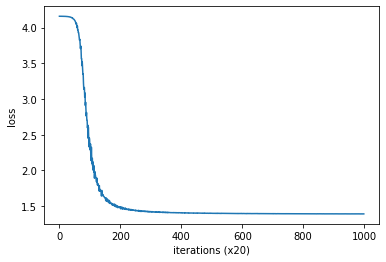

In [73]:
trainer.plot()

In [75]:
# check skip-gram results
### <your code> ###

studying [ 0.03509983  0.51529443 -0.9742502   1.727418    2.0924873 ]
language [ 0.14458317  1.736226    0.7649951   2.6704128  -0.12764466]
i [ 0.01455147 -0.00225844 -0.00152124 -0.00155948 -0.0171884 ]
processing [ 0.64390135 -1.6839404  -1.3443768  -0.9909441  -1.7128546 ]
natural [ 0.49661285 -2.2259881   0.7061572  -2.037493    0.51091766]
now [-0.49245292  0.77452797  0.9208236   0.89182234 -2.5126684 ]
. [ 0.00443482  0.00116071 -0.00473972  0.01033234  0.00074891]
am [-0.550826    0.53903264  0.5082179  -2.0508063   1.8738655 ]
